# Momentum conservation

Here we use a Jupyter notebook to analyze and plot the data from the physical experiment of bumping pucks together. In all of the trials, one of the pucks is initially stationary relative to the camera.

In [1083]:
#import the necessary pacakges

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize

letters = ['a', 'b']
setups = ['Elastic collision, equal masses', 'Elastic collision, unequal masses', 'Inelastic collision, equal masses']

# import the data
odata = [pd.read_csv(str(i//4+1) + "_" + str((i%4)//2+1) + "_" + letters[i%2] + ".csv") for i in range(12)]

### Plots
All the plots and analyses will be done simultaneously (with loops of code) for all of the trials.

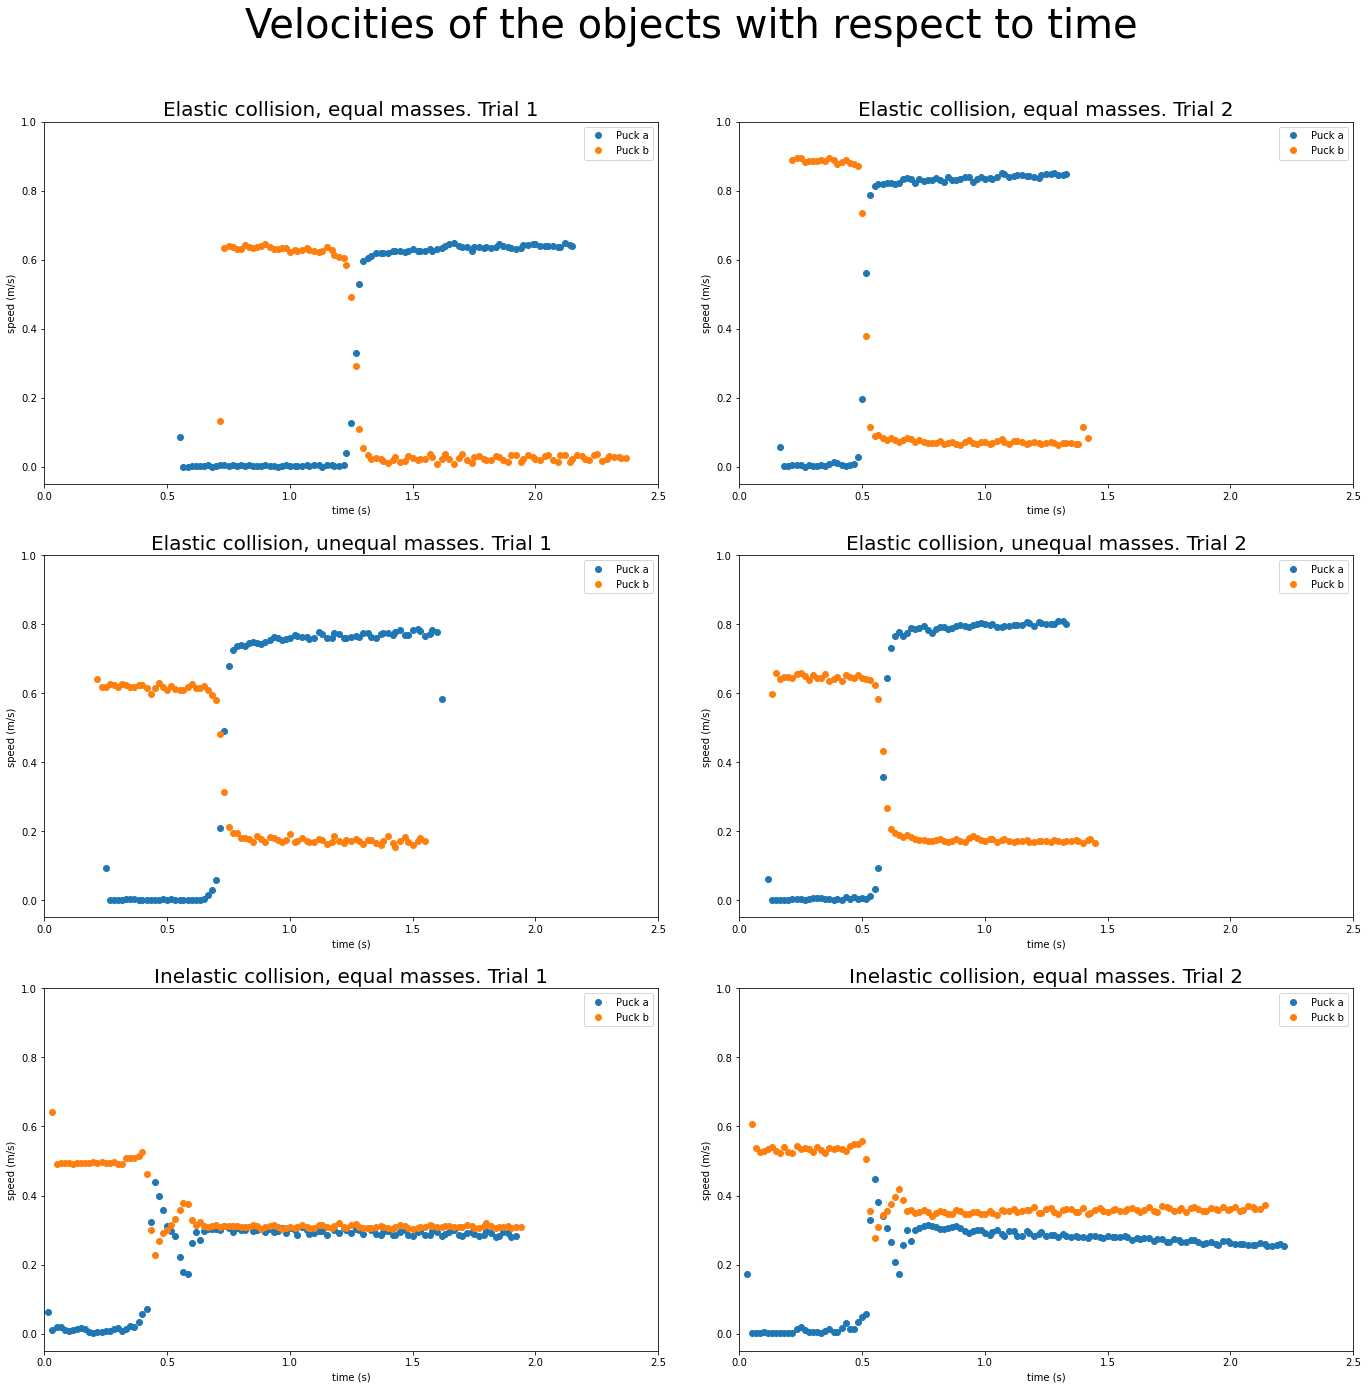

In [1084]:
def plot(data):
    fig, ax = plt.subplots(3, 2, figsize=(20, 20))
    fig.suptitle("Velocities of the objects with respect to time", size=40)
    fig.tight_layout(pad=5)

    for i in range(len(data)):
        x = data[i]["t"]
        y = data[i]["v"]
        ax[(i//2)//2, (i//2)%2].plot(x, y, "o", label="Puck " + letters[i%2])
        ax[(i//2)//2, (i//2)%2].set_title(setups[(i//2)//2] + ". Trial " + str((i%4)//2+1), size=20)
        ax[(i//2)//2, (i//2)%2].set(xlabel="time (s)", ylabel="speed (m/s)", xlim=[0,2.5], ylim=[-0.05, 1])

        ax[(i//2)//2, (i//2)%2].legend(loc="upper right")

plot(odata)

### Data cleaning
This process involves using the statistical convention of trimming the outliers, usually defined as data points that are beyond the interval [Q1-1.5*IQR, Q3+1.5*IQR], where Q1 is the first quartile, Q3 is the third quartile, and IQR is the interquartile range (Q3-Q1).

In [1085]:
# a function to take averages and standard deviations of the before and after collision data points
def befaf(ldat, lcolltime, comp='v'):
    lbef = np.array([0, 0], dtype='float64')
    laft = np.array([0, 0], dtype='float64')
    lqbefdat = np.array([])
    lqaftdat = np.array([])
    count = 0
    for i in range(len(ldat['t'])):
        if ldat['t'][i]<lcolltime:
            lbef[0] += ldat[comp][i]
            lqbefdat = np.append(lqbefdat, ldat[comp][i])
            count += 1
        elif ldat['t'][i]>=lcolltime:
            laft[0] += ldat[comp][i]
            lqaftdat = np.append(lqaftdat, ldat[comp][i])
    lbef[0] = lbef[0]/count
    laft[0] = laft[0]/(len(ldat['t'])-count)

    count = 0
    for i in range(len(ldat['t'])):
        if ldat['t'][i]<lcolltime:
            lbef[1] += (ldat[comp][i]-lbef[0])**2
            count += 1
        elif ldat['t'][i]>=lcolltime:
            laft[1] += (ldat[comp][i]-laft[0])**2
    lbef[1] = np.sqrt(lbef[1]/count)
    laft[1] = np.sqrt(laft[1]/(len(ldat['t'])-count))

    lqbef = np.array([np.percentile(lqbefdat, 25), np.percentile(lqbefdat, 75)])
    lqaft = np.array([np.percentile(lqaftdat, 25), np.percentile(lqaftdat, 75)])
    return lbef, laft, lqbef, lqaft

# a function to clean the before and after collision data points
def pluck(dat, colltime):
    dat.reset_index(drop=True, inplace=True)
    bef, aft, qbef, qaft = befaf(dat, colltime)
    margin = 2
    iqrbef = qbef[1] - qbef[0]
    iqraft = qaft[1] - qaft[0]
    iqrmargin = 1.5
    pointCount = 0
    mid = np.amax(np.array(dat.index[dat['t']<=colltime].tolist()))
    clean = False
    while not clean:
        clean = True
        j = 0
        while j < mid:
            vel = dat['v'][j]
            # if vel < bef[0]-margin*bef[1] or vel > bef[0]+margin*bef[1]:
            if vel < qbef[0]-iqrmargin*iqrbef or vel > qbef[1]+iqrmargin*iqrbef:
                dat.drop(j, axis=0, inplace=True)
                dat.reset_index(drop=True, inplace=True)
                bef, aft, qbef, qaft = befaf(dat, colltime)
                mid -= 1
                pointCount += 1
                clean = False
            j += 1
        last = len(dat['t'])
        while j < last:
            vel = dat['v'][j]
            # if vel < aft[0]-margin*aft[1] or vel > aft[0]+margin*aft[1]:
            if vel < qaft[0]-iqrmargin*iqraft or vel > qaft[1]+iqrmargin*iqraft:
                dat.drop(j, axis=0, inplace=True)
                dat.reset_index(drop=True, inplace=True)
                bef, aft, qbef, qaft = befaf(dat, colltime)
                last -= 1
                pointCount += 1
                clean = False
            j += 1
    return dat, pointCount

Total number of points removed from
Elastic collision, equal masses Trial 1 puck a are: 6
Elastic collision, equal masses Trial 1 puck b are: 9
Elastic collision, equal masses Trial 2 puck a are: 5
Elastic collision, equal masses Trial 2 puck b are: 11
Elastic collision, unequal masses Trial 1 puck a are: 9
Elastic collision, unequal masses Trial 1 puck b are: 9
Elastic collision, unequal masses Trial 2 puck a are: 8
Elastic collision, unequal masses Trial 2 puck b are: 12
Inelastic collision, equal masses Trial 1 puck a are: 12
Inelastic collision, equal masses Trial 1 puck b are: 16
Inelastic collision, equal masses Trial 2 puck a are: 9
Inelastic collision, equal masses Trial 2 puck b are: 7


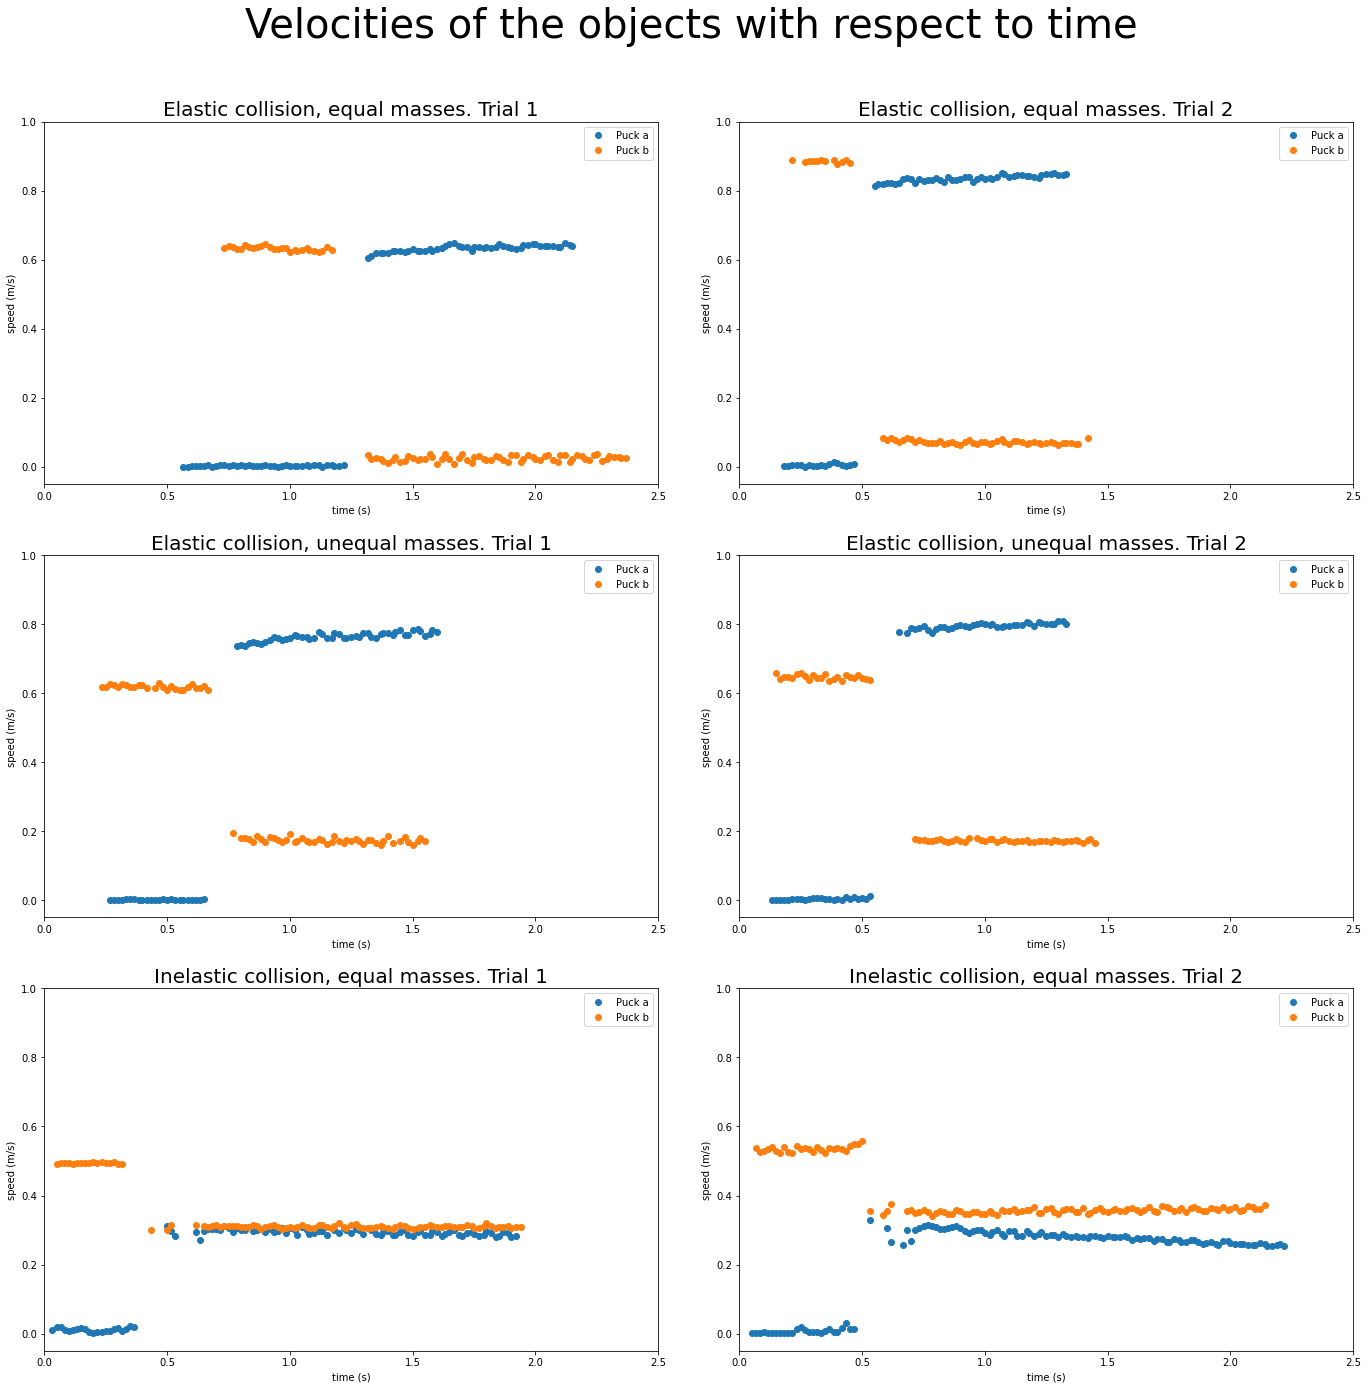

In [1086]:
# estimated collision time
ocolltime = np.array([1.25, 0.49, 0.7, 0.56, 0.43, 0.53])

# for dataWhatsoever in odata:
#     dataWhatsoever.dropna(axis=0, inplace=True)
#     dataWhatsoever = pluck(dataWhatsoever, ocolltime[odata.index(dataWhatsoever)//2])

print("Total number of points removed from")
for i in range(len(odata)):
    odata[i].dropna(axis=0, inplace=True)
    odata[i], pc = pluck(odata[i], ocolltime[i//2])
    print(f"{setups[(i//2)//2]} Trial {(i%4)//2+1} puck {letters[i%2]} are: {pc}")

plot(odata)

# note that in further analyses, this cleaner dataset will be the one used

## Analysis

#### Speed and kinetic energy
The speeds before and after the collisions are compared to each other for each trial for each setup.

In [1087]:
# these errors will be defined to be relative errors
speedbeferr = np.array([])
speedafterr = np.array([])

# change this to vary the uncertainty assigned to the output of the tracker software
sigma = 1.65

print("Average speed of")
for i in range(len(odata)):
    bef, aft, qbef, qaft = befaf(odata[i], ocolltime[i//2])
    speedbeferr = np.append(speedbeferr, sigma*bef[1]/bef[0])
    speedafterr = np.append(speedafterr, sigma*aft[1]/aft[0])
    print(f"{setups[(i//2)//2]} Trial {(i%4)//2+1} puck {letters[i%2]} (before):  \t {bef[0]:.4g} +/- {bef[0]*speedbeferr[i]:.2g} m/s")
    print(f"{setups[(i//2)//2]} Trial {(i%4)//2+1} puck {letters[i%2]} (after):  \t {aft[0]:.4g} +/- {aft[0]*speedafterr[i]:.2g} m/s")

Average speed of
Elastic collision, equal masses Trial 1 puck a (before):  	 0.003201 +/- 0.0031 m/s
Elastic collision, equal masses Trial 1 puck a (after):  	 0.6334 +/- 0.015 m/s
Elastic collision, equal masses Trial 1 puck b (before):  	 0.6327 +/- 0.0094 m/s
Elastic collision, equal masses Trial 1 puck b (after):  	 0.02475 +/- 0.012 m/s
Elastic collision, equal masses Trial 2 puck a (before):  	 0.004979 +/- 0.0053 m/s
Elastic collision, equal masses Trial 2 puck a (after):  	 0.8359 +/- 0.016 m/s
Elastic collision, equal masses Trial 2 puck b (before):  	 0.8856 +/- 0.0048 m/s
Elastic collision, equal masses Trial 2 puck b (after):  	 0.07194 +/- 0.0089 m/s
Elastic collision, unequal masses Trial 1 puck a (before):  	 0.001406 +/- 0.0021 m/s
Elastic collision, unequal masses Trial 1 puck a (after):  	 0.7641 +/- 0.02 m/s
Elastic collision, unequal masses Trial 1 puck b (before):  	 0.6185 +/- 0.0095 m/s
Elastic collision, unequal masses Trial 1 puck b (after):  	 0.1743 +/- 0.012

Here, the kinetic energies are compared.

In [1088]:
masses = np.array([0.19925, 0.19996, 0.19996, 0.32942, 0.19925, 0.19996])
masseserr = 0.00005/masses

KEbefore = np.array([])
KEbeferr = np.array([])
KEafter = np.array([])
KEafterr = np.array([])

print("Average kinetic energy of")
for i in range(len(odata)):
    bef, aft, qbef, qaft = befaf(odata[i], ocolltime[i//2])
    KEbefore = np.append(KEbefore, masses[(i%2)+((i//4)*2)]*bef[0]**2)
    KEbeferr = np.append(KEbeferr, np.sqrt(masseserr[(i%2)+((i//4)*2)]**2+2*speedbeferr[i]**2))
    KEafter = np.append(KEafter, masses[(i%2)+((i//4)*2)]*aft[0]**2)
    KEafterr = np.append(KEafterr, np.sqrt(masseserr[(i%2)+((i//4)*2)]**2+2*speedafterr[i]**2))
    # print(masses[(i%2)+((i//4)*2)])
    print(f"{setups[(i//2)//2]} Trial {(i%4)//2+1} puck {letters[i%2]} (before):  \t {KEbefore[i]:.4g} +/- {KEbefore[i]*KEbeferr[i]:.2g} J")
    print(f"{setups[(i//2)//2]} Trial {(i%4)//2+1} puck {letters[i%2]} (after):  \t {KEafter[i]:.4g} +/- {KEafter[i]*(KEafterr[i]):.2g} J")

Average kinetic energy of
Elastic collision, equal masses Trial 1 puck a (before):  	 2.042e-06 +/- 2.8e-06 J
Elastic collision, equal masses Trial 1 puck a (after):  	 0.07994 +/- 0.0027 J
Elastic collision, equal masses Trial 1 puck b (before):  	 0.08004 +/- 0.0017 J
Elastic collision, equal masses Trial 1 puck b (after):  	 0.0001225 +/- 8.7e-05 J
Elastic collision, equal masses Trial 2 puck a (before):  	 4.94e-06 +/- 7.5e-06 J
Elastic collision, equal masses Trial 2 puck a (after):  	 0.1392 +/- 0.0037 J
Elastic collision, equal masses Trial 2 puck b (before):  	 0.1568 +/- 0.0012 J
Elastic collision, equal masses Trial 2 puck b (after):  	 0.001035 +/- 0.00018 J
Elastic collision, unequal masses Trial 1 puck a (before):  	 3.955e-07 +/- 8.3e-07 J
Elastic collision, unequal masses Trial 1 puck a (after):  	 0.1167 +/- 0.0043 J
Elastic collision, unequal masses Trial 1 puck b (before):  	 0.126 +/- 0.0027 J
Elastic collision, unequal masses Trial 1 puck b (after):  	 0.01001 +/- 0

In [1089]:
print("Total kinetic energy of")
for i in range(1, len(odata), 2):
    print(f"{setups[(i//2)//2]} Trial {(i%4)//2+1} (before):  \t {KEbefore[i]+KEbefore[i-1]:.4g} +/- {np.sqrt((KEbefore[i]*KEbeferr[i])**2+(KEbefore[i-1]*KEbeferr[i-1])**2):.2g} J")
    print(f"{setups[(i//2)//2]} Trial {(i%4)//2+1} (after):  \t {KEafter[i]+KEafter[i-1]:.4g} +/- {np.sqrt((KEafter[i]*KEafterr[i])**2+(KEafter[i-1]*KEafterr[i-1])**2):.2g} J")

Total kinetic energy of
Elastic collision, equal masses Trial 1 (before):  	 0.08004 +/- 0.0017 J
Elastic collision, equal masses Trial 1 (after):  	 0.08006 +/- 0.0027 J
Elastic collision, equal masses Trial 2 (before):  	 0.1568 +/- 0.0012 J
Elastic collision, equal masses Trial 2 (after):  	 0.1402 +/- 0.0037 J
Elastic collision, unequal masses Trial 1 (before):  	 0.126 +/- 0.0027 J
Elastic collision, unequal masses Trial 1 (after):  	 0.1267 +/- 0.0044 J
Elastic collision, unequal masses Trial 2 (before):  	 0.1376 +/- 0.0033 J
Elastic collision, unequal masses Trial 2 (after):  	 0.1361 +/- 0.003 J
Inelastic collision, equal masses Trial 1 (before):  	 0.04879 +/- 0.00039 J
Inelastic collision, equal masses Trial 1 (after):  	 0.03648 +/- 0.0013 J
Inelastic collision, equal masses Trial 2 (before):  	 0.0573 +/- 0.0022 J
Inelastic collision, equal masses Trial 2 (after):  	 0.04113 +/- 0.0025 J


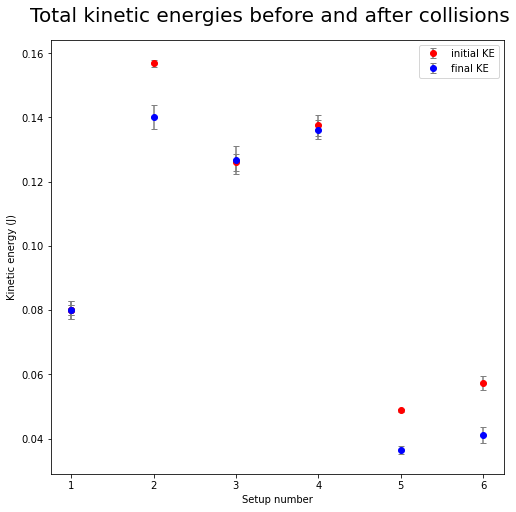

In [1090]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
fig.suptitle("Total kinetic energies before and after collisions", size=20)
fig.tight_layout(pad=1)

for i in range(1, len(odata), 2):
    if i==1:
        ax.errorbar(i//2+1, KEbefore[i]+KEbefore[i-1], yerr=np.sqrt((KEbefore[i]*KEbeferr[i])**2+(KEbefore[i-1]*KEbeferr[i-1])**2),
             fmt='o', color="red", ecolor="grey", capsize=3, label="initial KE")
        ax.errorbar(i//2+1, KEafter[i]+KEafter[i-1], yerr=np.sqrt((KEafter[i]*KEafterr[i])**2+(KEafter[i-1]*KEafterr[i-1])**2),
                fmt='o', color="blue", ecolor="grey", capsize=3, label="final KE")
    ax.errorbar(i//2+1, KEbefore[i]+KEbefore[i-1], yerr=np.sqrt((KEbefore[i]*KEbeferr[i])**2+(KEbefore[i-1]*KEbeferr[i-1])**2),
             fmt='o', color="red", ecolor="grey", capsize=3)
    ax.errorbar(i//2+1, KEafter[i]+KEafter[i-1], yerr=np.sqrt((KEafter[i]*KEafterr[i])**2+(KEafter[i-1]*KEafterr[i-1])**2),
             fmt='o', color="blue", ecolor="grey", capsize=3)
    ax.set(xlabel="Setup number", ylabel="Kinetic energy (J)")

    ax.legend(loc="upper right")

#### Velocity direction and momentum
The velocity components and angles are compared before and after collision for each trial for each setup.

In [1091]:
vbefore = np.empty((0,2))
vafter = np.empty((0,2))
vbeferr = np.empty((0,2))
vafterr = np.empty((0,2))
vradbef = np.array([])
vradbeferr = np.array([])
vradaft = np.array([])
vradafterr = np.array([])

print("Average angle with respect to the x-axis of the velocity vector of")
for i in range(len(odata)):
    befx, aftx, qbefx, qaftx = befaf(odata[i], ocolltime[i//2], 'v_{x}')
    befy, afty, qbefy, qafty = befaf(odata[i], ocolltime[i//2], 'v_{y}')
    vbefore = np.append(vbefore, [[befx[0], befy[0]]], axis=0)
    vafter = np.append(vafter, [[aftx[0], afty[0]]], axis=0)
    vbeferr = np.append(vbeferr, [[sigma*befx[1]/befx[0], sigma*befy[1]/befy[0]]], axis=0)
    vafterr = np.append(vafterr, [[sigma*afty[1]/afty[0], sigma*afty[1]/afty[0]]], axis=0)
    vradbef = np.append(vradbef, np.arctan(vbefore[i, 0]/vbefore[i, 1]))
    vradaft = np.append(vradaft, np.arctan(vafter[i, 0]/vafter[i, 1]))
    vradbeferr = np.append(vradbeferr, np.sqrt((vbefore[i, 0]*vbeferr[i, 0]*vbefore[i, 1])**2+(vbefore[i, 1]*vbeferr[i, 1]*vbefore[i, 0])**2)/(vradbef[i]*(vbefore[i, 0]**2+vbefore[i, 1]**2)))
    vradafterr = np.append(vradafterr, np.sqrt((vafter[i, 0]*vafterr[i, 0]*vafter[i, 1])**2+(vafter[i, 1]*vafterr[i, 1]*vafter[i, 0])**2)/(vradbef[i]*(vafter[i, 0]**2+vafter[i, 1]**2)))
    print(f"{setups[(i//2)//2]} Trial {(i%4)//2+1} puck {letters[i%2]} (before):  \t {vradbef[i]*180/np.pi:.4g} +/- {vradbef[i]*vradbeferr[i]*180/np.pi:.2g} degrees")
    print(f"{setups[(i//2)//2]} Trial {(i%4)//2+1} puck {letters[i%2]} (after):  \t {vradaft[i]*180/np.pi:.4g} +/- {vradaft[i]*vradafterr[i]*180/np.pi:.2g} degrees")

Average angle with respect to the x-axis of the velocity vector of
Elastic collision, equal masses Trial 1 puck a (before):  	 -28.21 +/- 3.6e+03 degrees
Elastic collision, equal masses Trial 1 puck a (after):  	 -2.107 +/- 0.0053 degrees
Elastic collision, equal masses Trial 1 puck b (before):  	 0.5897 +/- 0.88 degrees
Elastic collision, equal masses Trial 1 puck b (after):  	 -83.09 +/- -4.7e+03 degrees
Elastic collision, equal masses Trial 2 puck a (before):  	 -40.37 +/- 70 degrees
Elastic collision, equal masses Trial 2 puck a (after):  	 -2.217 +/- 0.0032 degrees
Elastic collision, equal masses Trial 2 puck b (before):  	 -0.3755 +/- 0.51 degrees
Elastic collision, equal masses Trial 2 puck b (after):  	 12.18 +/- -75 degrees
Elastic collision, unequal masses Trial 1 puck a (before):  	 26.1 +/- 7.7e+02 degrees
Elastic collision, unequal masses Trial 1 puck a (after):  	 -5.991 +/- -0.049 degrees
Elastic collision, unequal masses Trial 1 puck b (before):  	 0.5252 +/- 0.64 degre

The momentum components are compared before and after collision for each trial for each setup.

In [1092]:
pbefore = np.empty((0,2))
pafter = np.empty((0,2))
pbeferr = np.empty((0,2))
pafterr = np.empty((0,2))
pradbef = np.array([])
pradbeferr = np.array([])
pradaft = np.array([])
pradafterr = np.array([])

print("Momentum vector (p_x, p_y) of")
for i in range(len(odata)):
    pbefore = np.append(pbefore, [[vbefore[i, 0]*masses[(i%2)+((i//4)*2)], vbefore[i, 1]*masses[(i%2)+((i//4)*2)]]], axis=0)
    pafter = np.append(pafter, [[vafter[i, 0]*masses[(i%2)+((i//4)*2)], vafter[i, 1]*masses[(i%2)+((i//4)*2)]]], axis=0)
    pbeferr = np.append(pbeferr, [[np.sqrt(vbeferr[i, 0]**2+masseserr[(i%2)+((i//4)*2)]**2), np.sqrt(vbeferr[i, 1]**2+masseserr[(i%2)+((i//4)*2)]**2)]], axis=0)
    pafterr = np.append(pafterr, [[np.sqrt(vafterr[i, 0]**2+masseserr[(i%2)+((i//4)*2)]**2), np.sqrt(vafterr[i, 1]**2+masseserr[(i%2)+((i//4)*2)]**2)]], axis=0)
    print(f"{setups[(i//2)//2]} Trial {(i%4)//2+1} puck {letters[i%2]} (before):  \t ({pbefore[i, 1]:.4g} +/- {pbeferr[i, 1]*pbefore[i, 1]:.2g}, {pbefore[i, 0]:.4g} +/- {pbeferr[i, 0]*pbefore[i, 0]:.2g}) N s")
    print(f"{setups[(i//2)//2]} Trial {(i%4)//2+1} puck {letters[i%2]} (after):  \t ({pafter[i, 1]:.4g} +/- {pafterr[i, 1]*pafter[i, 1]:.2g}, {pafter[i, 0]:.4g} +/- {pafterr[i, 0]*pafter[i, 0]:.2g}) N s")


Momentum vector (p_x, p_y) of
Elastic collision, equal masses Trial 1 puck a (before):  	 (1.09e-05 +/- 0.00098, -5.845e-06 +/- -0.00072) N s
Elastic collision, equal masses Trial 1 puck a (after):  	 (0.1261 +/- 0.003, -0.00464 +/- -0.00011) N s
Elastic collision, equal masses Trial 1 puck b (before):  	 (0.1265 +/- 0.0019, 0.001302 +/- 0.0019) N s
Elastic collision, equal masses Trial 1 puck b (after):  	 (-0.0005749 +/- -0.002, 0.004747 +/- 0.017) N s
Elastic collision, equal masses Trial 2 puck a (before):  	 (0.0006216 +/- 0.00099, -0.0005285 +/- -0.001) N s
Elastic collision, equal masses Trial 2 puck a (after):  	 (0.1664 +/- 0.0031, -0.006442 +/- -0.00012) N s
Elastic collision, equal masses Trial 2 puck b (before):  	 (0.1771 +/- 0.00097, -0.001161 +/- -0.0016) N s
Elastic collision, equal masses Trial 2 puck b (after):  	 (0.01402 +/- 0.0019, 0.003025 +/- 0.00042) N s
Elastic collision, unequal masses Trial 1 puck a (before):  	 (3.184e-05 +/- 0.00037, 1.56e-05 +/- 0.0005) N 

In [1093]:
print("Total momentum (p_x, p_y) of")
for i in range(1, len(odata), 2):
    print(f"{setups[(i//2)//2]} Trial {(i%4)//2+1} (before):  \t ({pbefore[i, 1]+pbefore[i-1, 1]:.4g} +/- {np.sqrt((pbeferr[i, 1]*pbefore[i, 1])**2+(pbeferr[i-1, 1]*pbefore[i-1, 1])**2):.2g},\t {pbefore[i, 0]+pbefore[i-1, 0]:.4g} +/- {np.sqrt((pbeferr[i, 0]*pbefore[i, 0])**2+(pbeferr[i-1, 0]*pbefore[i-1, 0])**2):.2g}) N s")
    print(f"{setups[(i//2)//2]} Trial {(i%4)//2+1} (after):  \t ({pafter[i, 1]+pafter[i-1, 1]:.4g} +/- {np.sqrt((pafterr[i, 1]*pafter[i, 1])**2+(pafterr[i-1, 1]*pafter[i-1, 1])**2):.2g},\t {pafter[i, 0]+pafter[i-1, 0]:.4g} +/- {np.sqrt((pafterr[i, 0]*pafter[i, 0])**2+(pafterr[i-1, 0]*pafter[i-1, 0])**2):.2g}) N s")

Total momentum (p_x, p_y) of
Elastic collision, equal masses Trial 1 (before):  	 (0.1265 +/- 0.0021,	 0.001296 +/- 0.0021) N s
Elastic collision, equal masses Trial 1 (after):  	 (0.1256 +/- 0.0036,	 0.0001068 +/- 0.017) N s
Elastic collision, equal masses Trial 2 (before):  	 (0.1777 +/- 0.0014,	 -0.001689 +/- 0.0019) N s
Elastic collision, equal masses Trial 2 (after):  	 (0.1804 +/- 0.0037,	 -0.003417 +/- 0.00044) N s
Elastic collision, unequal masses Trial 1 (before):  	 (0.2038 +/- 0.0031,	 0.001883 +/- 0.0023) N s
Elastic collision, unequal masses Trial 1 (after):  	 (0.2069 +/- 0.0056,	 0.0007617 +/- 0.0013) N s
Elastic collision, unequal masses Trial 2 (before):  	 (0.213 +/- 0.0038,	 0.008706 +/- 0.0028) N s
Elastic collision, unequal masses Trial 2 (after):  	 (0.2155 +/- 0.0031,	 0.009482 +/- 0.00014) N s
Inelastic collision, equal masses Trial 1 (before):  	 (0.09707 +/- 0.0013,	 0.004239 +/- 0.0016) N s
Inelastic collision, equal masses Trial 1 (after):  	 (0.1203 +/- 0.0

And plotting the momentum vectors just for fun

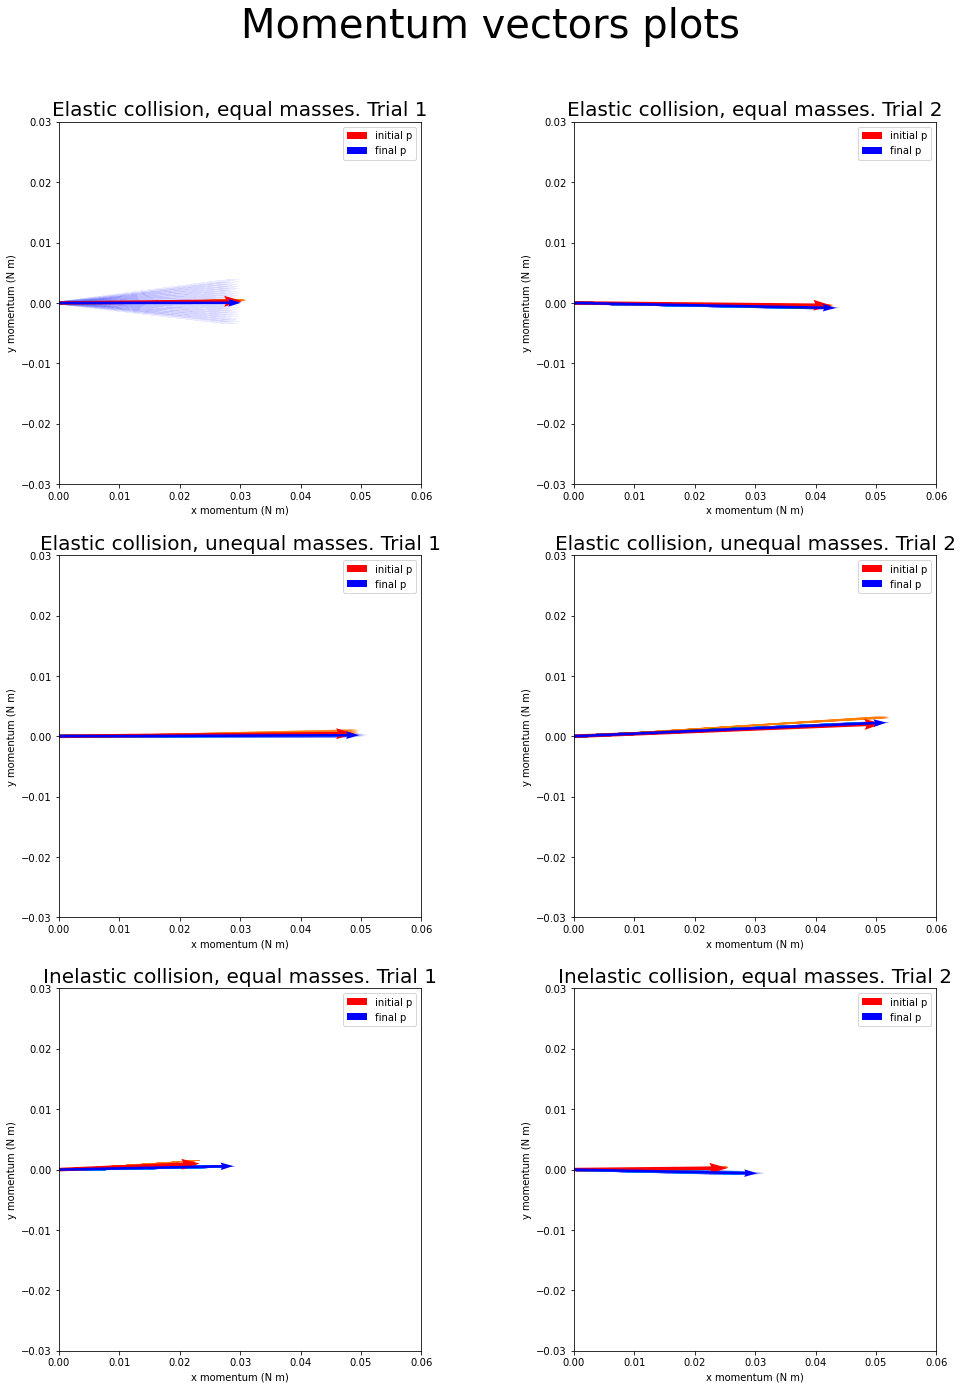

In [1094]:
origin = np.zeros((2,1))

fig, ax = plt.subplots(3, 2, figsize=(15, 20))
fig.suptitle("Momentum vectors plots", size=40)
fig.tight_layout(pad=5)

for i in range(1, len(odata), 2):

    # to visualize the uncertainty in the vectors
    upbefore = np.array([[pbefore[i, 1]+pbefore[i-1, 1]+pbefore[i, 1]*pbeferr[i, 1]+pbefore[i-1, 1]*pbeferr[i-1, 1], pbefore[i, 1]+pbefore[i-1, 1]-pbefore[i, 1]*pbeferr[i, 1]-pbefore[i-1, 1]*pbeferr[i-1, 1]], pbefore[i, 0]+pbefore[i-1, 0]+[pbefore[i, 0]*pbeferr[i, 0]+pbefore[i-1, 0]*pbeferr[i-1, 0], pbefore[i, 0]+pbefore[i-1, 0]-pbefore[i, 0]*pbeferr[i, 0]-pbefore[i-1, 0]*pbeferr[i-1, 0]]])
    upafter = np.array([[pafter[i, 1]+pafter[i-1, 1]+pafter[i, 1]*pafterr[i, 1]+pafter[i-1, 1]*pafterr[i-1, 1], pafter[i, 1]+pafter[i-1, 1]-pafter[i, 1]*pafterr[i, 1]-pafter[i-1, 1]*pafterr[i-1, 1]], [pafter[i, 0]+pafter[i-1, 0]+pafter[i, 0]*pafterr[i, 0]+pafter[i-1, 0]*pafterr[i-1, 0], pafter[i, 0]+pafter[i-1, 0]-pafter[i, 0]*pafterr[i, 0]-pafter[i-1, 0]*pafterr[i-1, 0]]])

    div = 20
    for j in range(div):
        for k in range(div):
            ax[(i//2)//2, (i//2)%2].quiver(*origin, upbefore[0, 0] + j*(upbefore[0, 1]-upbefore[0, 0])/div, upbefore[1, 0] + k*(upbefore[1, 1]-upbefore[1, 0])/div, color=(1,0.5,0,0.05), width=0.001, headwidth=1, scale=0.25)
            ax[(i//2)//2, (i//2)%2].quiver(*origin, upafter[0, 0] + j*(upafter[0, 1]-upafter[0, 0])/div, upafter[1, 0] + k*(upafter[1, 1]-upafter[1, 0])/div, color=(0,0.5,1,0.005), width=0.01, headwidth=1, scale=0.25)

    ax[(i//2)//2, (i//2)%2].quiver(*origin, pbefore[i, 1]+pbefore[i-1, 1], pbefore[i, 0]+pbefore[i-1, 0], color='r', width=0.01, scale=0.25, label='initial p')
    ax[(i//2)//2, (i//2)%2].quiver(*origin, pafter[i, 1]+pafter[i-1, 1], pafter[i, 0]+pafter[i-1, 0], color='b', width=0.007, scale=0.25, label='final p')

    ax[(i//2)//2, (i//2)%2].set_title(setups[(i//2)//2] + ". Trial " + str((i%4)//2+1), size=20)
    ax[(i//2)//2, (i//2)%2].set(xlabel="x momentum (N m)", ylabel="y momentum (N m)", xlim=[0, 0.06], ylim=[-0.03, 0.03])
    ax[(i//2)//2, (i//2)%2].set_aspect('equal')
    ax[(i//2)//2, (i//2)%2].legend(loc="upper right")